In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

dataset_path= "Brightkite_edges.txt"

def parseDataset(path):
    df = pd.read_table(path, delimiter='\t', names=['source','target'])
    return df

In [6]:
#Graph creation
data = parseDataset(dataset_path)
G= nx.from_pandas_edgelist(data,"source","target")


Graph with 58228 nodes and 214078 edges


In [17]:
#generic analysis
print(G)


Graph with 58228 nodes and 214078 edges
Graph with 58228 nodes and 214078 edges
Il grafo è connesso? False
Componenti connesse: 547


/tmp/ipykernel_19241/1189280283.py:3: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


In [8]:
#largest connected component
print("Il grafo è connesso? "+str(nx.is_connected(G)))
print("Componenti connesse: "+ str(nx.number_connected_components(G)))
core_nodes = max(nx.connected_components(G), key=len)
print(f"largest connected component size: {len(core_nodes)}")
core = G.subgraph(core_nodes)


#nx.draw(core, with_labels=True)

largest connected component size: 56739


average degree: 7.353094731057223
21157


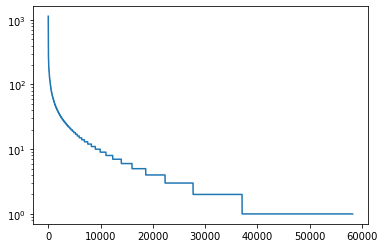

In [16]:
#degree analysis
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
plt.yscale('log')
plt.plot(degree_sequence)

print("average degree: " + str(sum(degree_sequence)/len(degree_sequence)))
#wtf? average degree 7?
print(degree_sequence.count(min(degree_sequence)))
#ah, ecco perchè.

In [10]:
#clustering coefficient
print("Clustering coefficient: "+str(nx.average_clustering(G)))


Clustering coefficient: 0.17232592744613273
